<a href="https://colab.research.google.com/github/rahu2004/diabetes-predition/blob/main/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install tensorflow==2.12.0
!pip install statsmodels==0.14.0
!pip install numpy==1.23.5
!pip install scikit-learn==1.2.2
!pip install seaborn==0.12.2
!pip install matplotlib==3.7.1
!pip install pandas==2.0.2
!pip install yfinance==0.2.18
!pip install pandas_datareader==0.10.0
!pip install pandas_ta==0.3.14b
!pip install projectpro

ERROR: Operation cancelled by user
  Preparing metadata (setup.py) ... done
  Created wheel for projectpro: filename=projectpro-0.0.29-py3-none-any.whl size=8053 sha256=b7e8b1547d183aa3cf417e2e1419726c99c141a5f3c7271b7217c643bc2f9336
  Stored in directory: /root/.cache/pip/wheels/c9/e6/d2/b51810169aa7a8d980e420564e0f3fb8a51d4bcf3fd960c3b1
Successfully built projectpro


In [ ]:
from datetime import datetime
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import yfinance as yf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
import pandas_ta as ta
from projectpro import model_snapshot, checkpoint
from keras.layers import LSTM, SimpleRNN
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
keras.backend.set_image_data_format("channels_last")
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
yf.pdr_override()
%matplotlib inline

In [ ]:
abalone_features = ["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
                    "Viscera weight", "Shell weight", "Age"]

In [ ]:
abalone_train = pd.read_csv(
    "https://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv",
    names=abalone_features)

abalone_test = pd.read_csv(
    "https://storage.googleapis.com/download.tensorflow.org/data/abalone_test.csv",
    names=abalone_features)
checkpoint('34db30')

<IPython.core.display.Javascript object>

In [ ]:
abalone_train.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age
0,0.435,0.335,0.110,0.334,0.1355,0.0775,0.0965,7
1,0.585,0.450,0.125,0.874,0.3545,0.2075,0.2250,6
2,0.655,0.510,0.160,1.092,0.3960,0.2825,0.3700,14
3,0.545,0.425,0.125,0.768,0.2940,0.1495,0.2600,16
4,0.545,0.420,0.130,0.879,0.3740,0.1695,0.2300,13


In [ ]:
abalone_train_features = abalone_train.copy()
abalone_train_labels = abalone_train_features.pop('Age')

In [ ]:
abalone_test_features = abalone_test.copy()
abalone_test_labels = abalone_test_features.pop('Age')

In [ ]:
normalize = tf.keras.layers.Normalization()
normalize.adapt(abalone_train_features)

In [ ]:
abalone_model = tf.keras.Sequential([
    normalize, tf.keras.layers.Dense(64), tf.keras.layers.Dense(1)
])

In [ ]:
abalone_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                      optimizer=tf.keras.optimizers.Adam())

In [ ]:
abalone_model.fit(abalone_train_features, abalone_train_labels, epochs=10)

Epoch 1/10
104/104 [==============================] - 2s 2ms/step - loss: 93.7786
Epoch 2/10
104/104 [==============================] - 0s 2ms/step - loss: 55.9922
Epoch 3/10
104/104 [==============================] - 0s 2ms/step - loss: 17.8482
Epoch 4/10
104/104 [==============================] - 0s 2ms/step - loss: 5.8680
Epoch 5/10
104/104 [==============================] - 0s 2ms/step - loss: 5.0268
Epoch 6/10
104/104 [==============================] - 0s 2ms/step - loss: 4.9646
Epoch 7/10
104/104 [==============================] - 0s 2ms/step - loss: 4.9432
Epoch 8/10
104/104 [==============================] - 0s 2ms/step - loss: 4.9341
Epoch 9/10
104/104 [==============================] - 0s 2ms/step - loss: 4.9460
Epoch 10/10
104/104 [==============================] - 0s 2ms/step - loss: 4.9203


In [ ]:
predictions = abalone_model.predict(abalone_test_features)

27/27 [==============================] - 0s 5ms/step


In [ ]:
squared_error = tf.keras.metrics.MeanSquaredError()
squared_error.update_state(abalone_test_labels, predictions)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1.0>

In [ ]:
print(f'Mean Squared error for test set: {squared_error.result().numpy()}')

Mean Squared error for test set: 5.566487789154053


In [ ]:
dataset = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.now())

[*********************100%***********************]  1 of 1 completed


In [ ]:
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.466095,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.533089,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.672226,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.804701,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.784391,394024400


In [ ]:
tstart = 2016
tend = 2020

In [ ]:
def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("Apple stock price")
    plt.show()

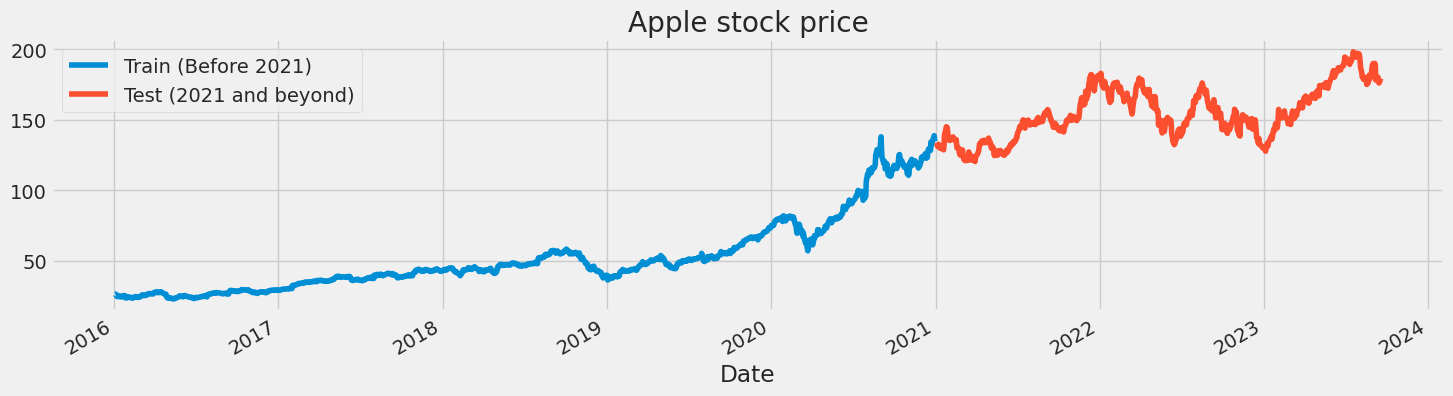

In [ ]:
train_test_plot(dataset, tstart, tend)

In [ ]:
def train_test_split(dataset, tstart, tend, columns = ['High']):
    train = dataset.loc[f"{tstart}":f"{tend}", columns].values
    test = dataset.loc[f"{tend+1}":, columns].values
    return train, test

In [ ]:
training_set, test_set = train_test_split(dataset, tstart, tend)

In [ ]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)


In [ ]:
n_steps = 1
features = 1

In [ ]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [ ]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], features)

In [ ]:
def plot_predictions(test, predicted, title):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title(f'{title}')
    plt.xlabel("Time")
    plt.ylabel(f'{title}')
    plt.legend()
    plt.show()

In [ ]:
def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

In [ ]:
def plot_loss(history):
    plt.figure(figsize = (15,10))
    plt.plot(history.history['loss'], label='loss')
    plt.legend(loc='best')
    plt.show()

In [ ]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=125, input_shape=(n_steps, features)))
model_rnn.add(Dense(units=1))

In [ ]:
# Compiling the model
model_rnn.compile(optimizer="RMSprop", loss="mse")

In [ ]:
history = model_rnn.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
model_snapshot("34db30")

<IPython.core.display.Javascript object>

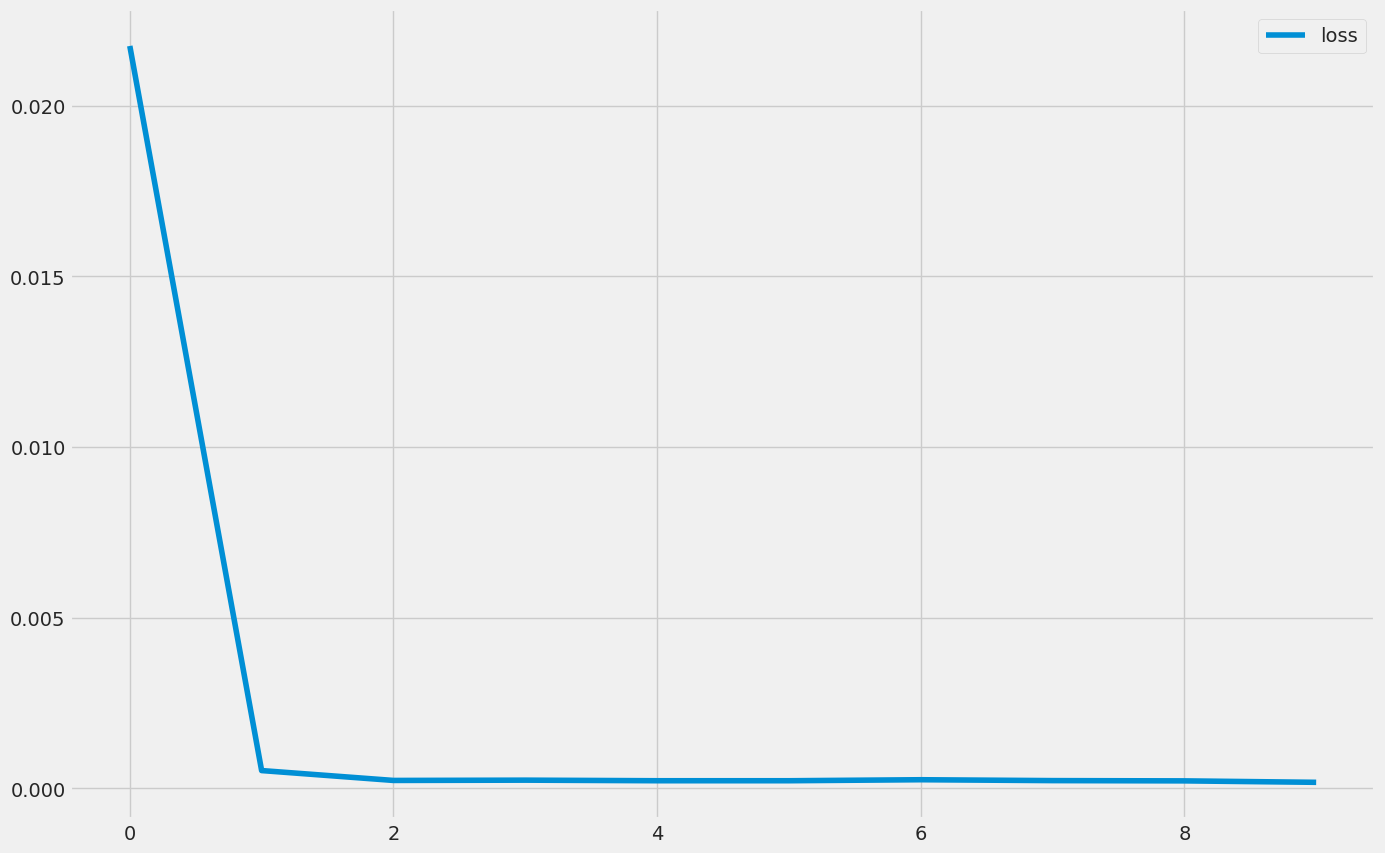

In [ ]:
plot_loss(history)

In [ ]:
# Scaling
inputs = sc.transform(test_set.reshape(-1, 1))

In [ ]:
# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(-1, n_steps, features)

In [ ]:
# Prediction
predicted_stock_price = model_rnn.predict(X_test)
# Inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

22/22 [==============================] - 0s 3ms/step


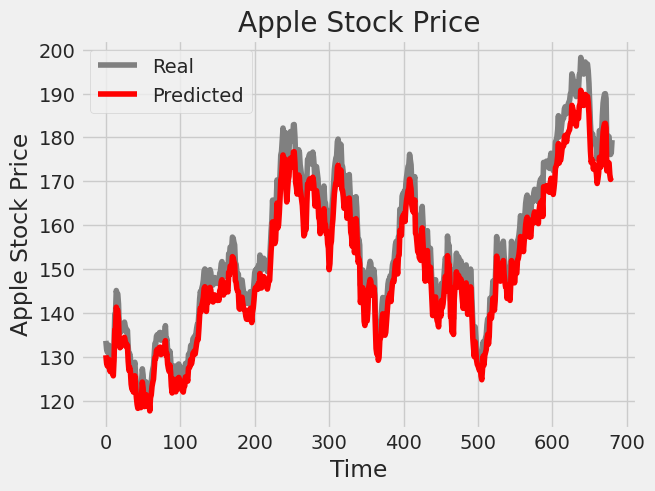

In [ ]:
plot_predictions(test_set, predicted_stock_price, "Apple Stock Price")

In [ ]:
steps_in_future = 25

In [ ]:
def sequence_generation(dataset: pd.DataFrame, sc: MinMaxScaler, model:Sequential, steps_future: int):
    high_dataset = dataset.iloc[len(dataset) - len(test_set) - n_steps:]["High"]
    high_dataset = sc.transform(high_dataset.values.reshape(-1, 1))
    inputs = high_dataset[:n_steps]

    for _ in range(steps_future):
        curr_pred = model.predict(inputs[-n_steps:].reshape(-1, n_steps, features), verbose=0)
        inputs = np.append(inputs, curr_pred, axis=0)

    return sc.inverse_transform(inputs[n_steps:])

In [ ]:
results = sequence_generation(dataset, sc, model_rnn, steps_in_future)

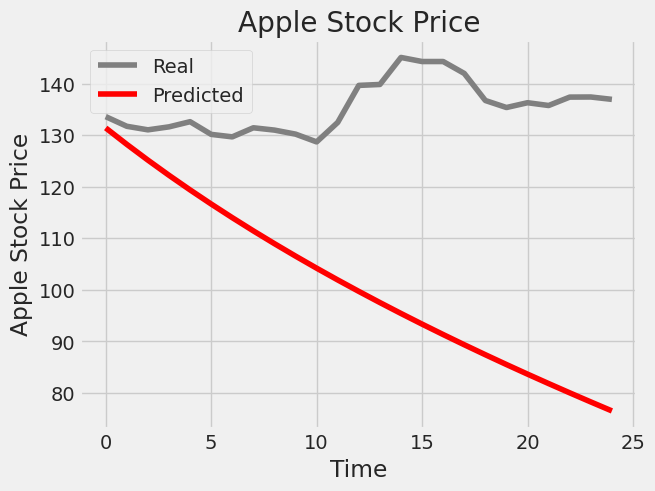

In [ ]:
plot_predictions(test_set[:steps_in_future], results, "Apple Stock Price")

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))

In [ ]:
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

In [ ]:
history = model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

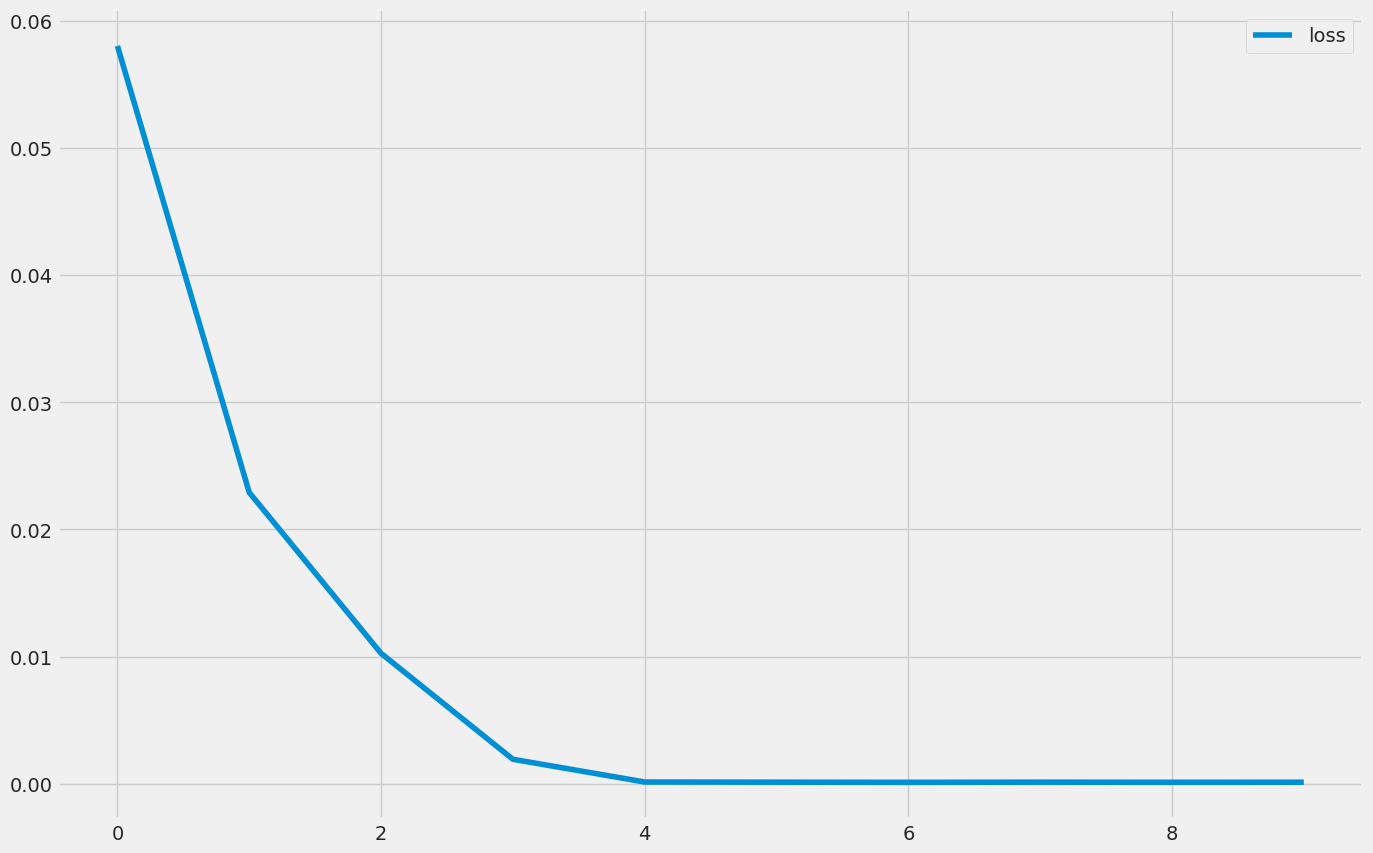

In [ ]:
plot_loss(history)

In [ ]:
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

22/22 [==============================] - 1s 4ms/step


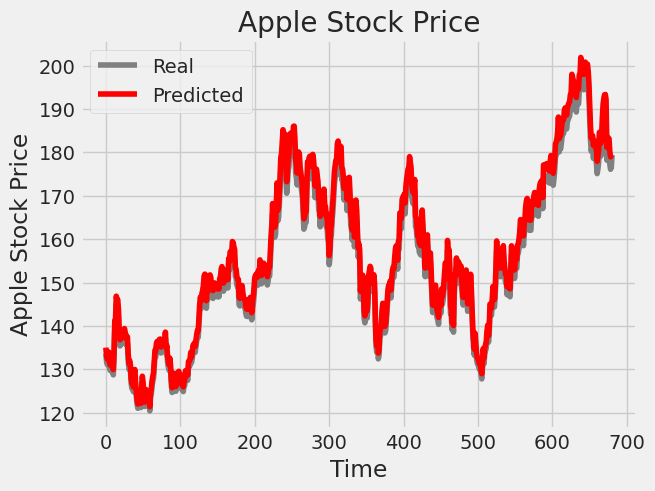

In [ ]:
plot_predictions(test_set, predicted_stock_price, "Apple Stock Price")

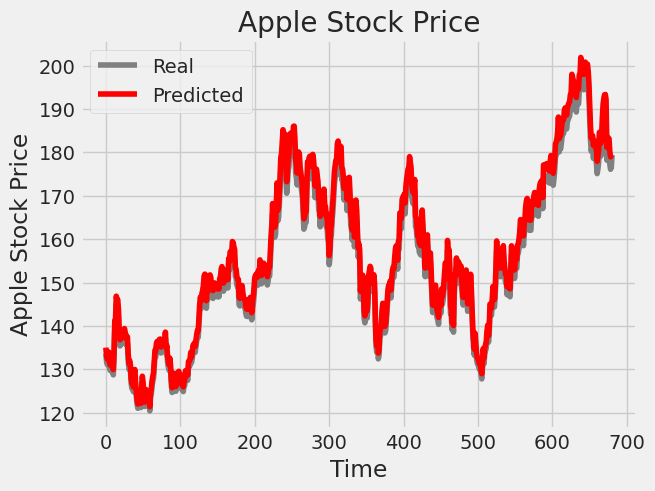

In [ ]:
plot_predictions(test_set, predicted_stock_price, "Apple Stock Price")

In [ ]:
results = sequence_generation(dataset, sc, model_lstm, steps_in_future)

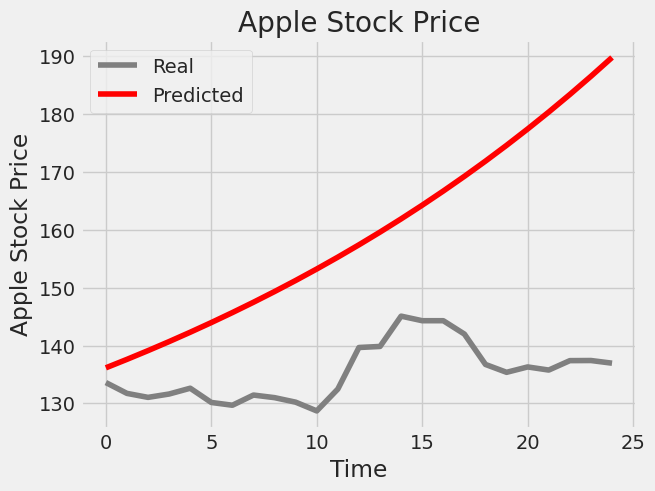

In [ ]:
plot_predictions(test_set[:steps_in_future], results, "Apple Stock Price")

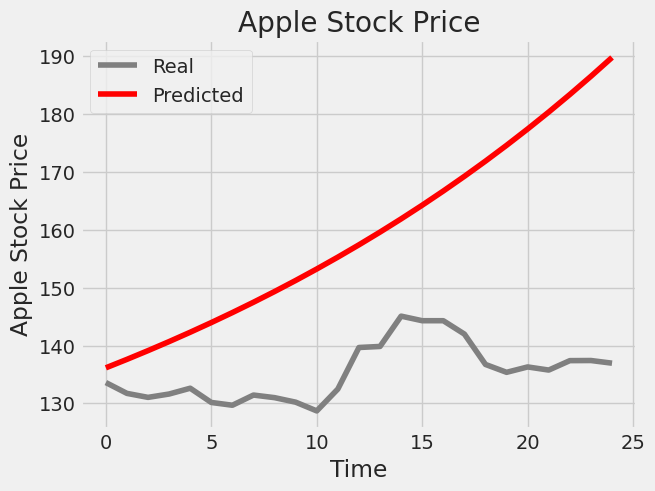

In [ ]:
plot_predictions(test_set[:steps_in_future], results, "Apple Stock Price")

In [ ]:
mv_features = 6

In [ ]:
multi_variate_df = dataset.copy()


In [ ]:
multi_variate_df['RSI'] = ta.rsi(multi_variate_df.Close, length=15)
multi_variate_df['EMAF'] = ta.ema(multi_variate_df.Close, length=20)
multi_variate_df['EMAM'] = ta.ema(multi_variate_df.Close, length=100)
multi_variate_df['EMAS'] = ta.ema(multi_variate_df.Close, length=150)

In [ ]:
multi_variate_df['Target'] = multi_variate_df['Adj Close'] - dataset.Open
multi_variate_df['Target'] = multi_variate_df['Target'].shift(-1)
multi_variate_df.dropna(inplace=True)
multi_variate_df.drop(['Volume', 'Close'], axis=1, inplace=True)

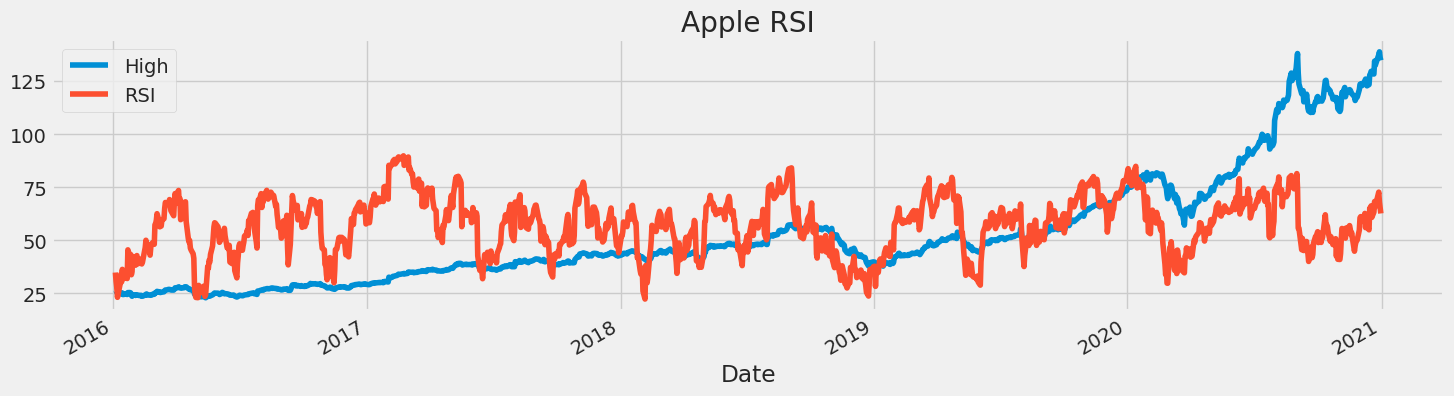

In [ ]:
multi_variate_df.loc[f"{tstart}":f"{tend}", ['High', 'RSI']].plot(figsize=(16, 4), legend=True)
plt.title("Apple RSI")
plt.show()

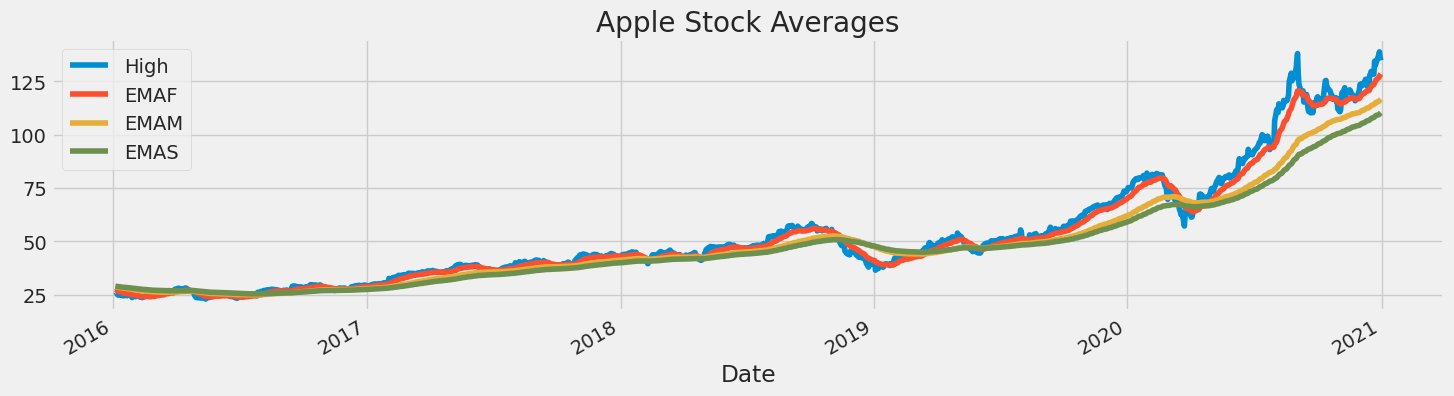

In [ ]:
multi_variate_df.loc[f"{tstart}":f"{tend}", ['High', 'EMAF', 'EMAM', 'EMAS']].plot(figsize=(16, 4), legend=True)
plt.title("Apple Stock Averages")
plt.show()